In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import feature.scrna_dataset as scrna_dataset
import model.sdes as sdes
import model.generate as generate
import model.scrna_ae as scrna_ae
import model.util as model_util
import analysis.fid as fid
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import h5py
import json
import time

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

branched_model_path = os.path.join(models_base_path, "scrna_covid_flu_continuous_branched_9classes_latent_d200/3/last_ckpt.pth")

In [5]:
def import_classes_branch_points(json_path):
    with open(json_path, "r") as f:
        d = json.load(f)
        return d["classes"], \
            [(tuple(trip[0]), trip[1], trip[2]) for trip in d["branches"]]
    
classes, branch_defs = import_classes_branch_points(
    "/gstore/home/tsenga5/branched_diffusion/data/config/classes_branch_points/scrna_covid_flu/redset.json"
)

In [6]:
latent_space = True
latent_dim = 200

In [7]:
data_file = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/scrna/covid_flu/processed/covid_flu_processed_reduced_genes.h5"
autoencoder_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_processed_reduced_genes_ldvae_d%d/" % latent_dim

In [8]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/scrna_covid_flu_efficiency"

os.makedirs(out_path, exist_ok=True)

### Create data loader

In [9]:
dataset = scrna_dataset.SingleCellDataset(data_file, autoencoder_path=(autoencoder_path if latent_space else None))

# Limit classes
inds = np.isin(dataset.cell_cluster, classes)
dataset.data = dataset.data[inds]
dataset.cell_cluster = dataset.cell_cluster[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)
input_shape = next(iter(data_loader))[0].shape[1:]

[rank: 0] Global seed set to 0


INFO     File                                                                                                      
         /gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/scrna_vaes/covid_flu/covid_flu_proc
         essed_reduced_genes_ldvae_d200/model.pt already downloaded                                                


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/gstore/home/tsenga5/miniconda3/envs/scanpy/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [10]:
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

In [11]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t, branch_defs):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t, branch_defs):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i, branch_defs) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Import models

In [12]:
branched_model = model_util.load_model(
    scrna_ae.MultitaskResNet, branched_model_path
).to(DEVICE)

### Generating multiple classes

In [13]:
# Sample each class individually without taking advantage of branches
num_linear_trials = 10
linear_times = []
for _ in range(num_linear_trials):
    time_a = time.time()
    for class_to_sample in classes:
        print("Sampling class: %s" % class_to_sample)
        generate.generate_continuous_branched_samples(
            branched_model, sde, class_to_sample,
            lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
            sampler="pc", t_limit=t_limit, num_steps=1000
        )
    time_b = time.time()
    time_taken = time_b - time_a
    linear_times.append(time_taken)
    print("Total time taken: %ds" % time_taken)
print("Average time taken: %.2f +/- %.2f" % (np.mean(linear_times), np.std(linear_times) / np.sqrt(len(linear_times))))

Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 7
Sampling class: 10
Sampling class: 12
Total time taken: 275s
Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 7
Sampling class: 10
Sampling class: 12
Total time taken: 275s
Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 7
Sampling class: 10
Sampling class: 12
Total time taken: 275s
Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 7
Sampling class: 10
Sampling class: 12
Total time taken: 275s
Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling class: 3
Sampling class: 4
Sampling class: 5
Sampling class: 7
Sampling class: 10
Sampling class: 12
Total time taken: 275s
Sampling class: 0
Sampling class: 1
Sampling class: 2
Sampling cl

In [14]:
# Sample each object by taking advantage of branches
num_branched_trials = 10
branched_times = []

# Sort the branches by starting time point (in reverse order), and generate along those
# branches, caching results; this guarantees that we will always find a cached batch
# (other than the first one)
cache = {}
sorted_branch_defs = sorted(branch_defs, key=(lambda t: -t[1]))

for _ in range(num_branched_trials):
    time_a = time.time()
    # First branch
    print("Sampling branch 1/%d" % len(sorted_branch_defs))
    branch_def = sorted_branch_defs[0]
    samples = generate.generate_continuous_branched_samples(
        # Specify arbitrary class
        branched_model, sde, branch_def[0][0],
        lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
        sampler="pc", t_limit=branch_def[2], t_start=branch_def[1],
        num_steps=int(1000 * (branch_def[2] - branch_def[1]))
    )
    for class_i in branch_def[0]:
        cache[class_i] = (branch_def[1], samples)

    for i, branch_def in enumerate(sorted_branch_defs[1:]):
        print("Sampling branch %d/%d" % (i + 2, len(sorted_branch_defs)))
        cached_time, cached_samples = cache[branch_def[0][0]]
        assert cached_time == branch_def[2]
        samples = generate.generate_continuous_branched_samples(
            branched_model, sde, branch_def[0][0],
            lambda c, t: class_time_to_branch_tensor(c, t, branch_defs),
            sampler="pc", t_limit=branch_def[2], t_start=branch_def[1],
            num_steps=int(1000 * (branch_def[2] - branch_def[1])),
            initial_samples=cached_samples
        )
        for class_i in branch_def[0]:
            cache[class_i] = (branch_def[1], samples)

    time_b = time.time()
    time_taken = time_b - time_a
    branched_times.append(time_taken)
    print("Total time taken: %ds" % time_taken)
print("Average time taken: %.2f +/- %.2f" % (np.mean(branched_times), np.std(branched_times) / np.sqrt(len(branched_times))))

Sampling branch 1/17
Sampling branch 2/17
Sampling branch 3/17
Sampling branch 4/17
Sampling branch 5/17
Sampling branch 6/17
Sampling branch 7/17
Sampling branch 8/17
Sampling branch 9/17
Sampling branch 10/17
Sampling branch 11/17
Sampling branch 12/17
Sampling branch 13/17
Sampling branch 14/17
Sampling branch 15/17
Sampling branch 16/17
Sampling branch 17/17
Total time taken: 132s
Sampling branch 1/17
Sampling branch 2/17
Sampling branch 3/17
Sampling branch 4/17
Sampling branch 5/17
Sampling branch 6/17
Sampling branch 7/17
Sampling branch 8/17
Sampling branch 9/17
Sampling branch 10/17
Sampling branch 11/17
Sampling branch 12/17
Sampling branch 13/17
Sampling branch 14/17
Sampling branch 15/17
Sampling branch 16/17
Sampling branch 17/17
Total time taken: 132s
Sampling branch 1/17
Sampling branch 2/17
Sampling branch 3/17
Sampling branch 4/17
Sampling branch 5/17
Sampling branch 6/17
Sampling branch 7/17
Sampling branch 8/17
Sampling branch 9/17
Sampling branch 10/17
Sampling bran

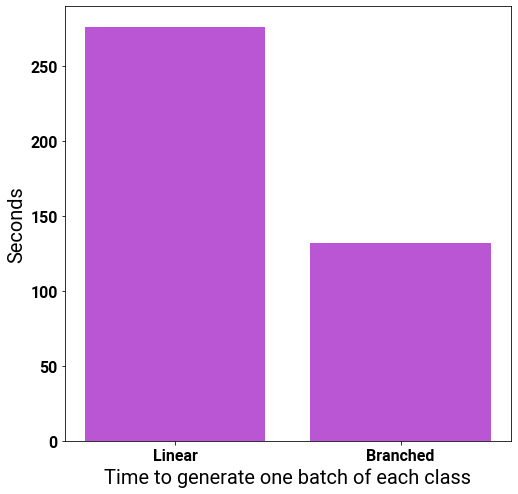

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
labels = ["Linear", "Branched"]
times = [np.mean(linear_times), np.mean(branched_times)]
errors = [np.std(linear_times) / np.sqrt(num_linear_trials), np.std(branched_times) / np.sqrt(num_branched_trials)]
ax.bar(labels, times, color="mediumorchid")
ax.errorbar(labels, times, yerr=errors, fmt="none", color="darkmagenta")
ax.set_xlabel("Time to generate one batch of each class")
ax.set_ylabel("Seconds")
plt.show()
fig.savefig(
    os.path.join(out_path, "scrna_covid_flu_efficiency.svg"),
    format="svg"
)